In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from pandasticsearch import Select, DataFrame

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Notebook - Kabana lookalike

In [43]:
from IPython.display import Image
image="https://i0.wp.com/sisypheanhigh.com/foot/wp-content/uploads/2015/08/sisyphus-red.png"
Image(url=image)

In [44]:
hostname="http://noname.us.cray.com:30200"
client =  Elasticsearch(hostname, http_compress=True)

In [49]:
cluster_health=client.cluster.health()
#cluster_health

In [8]:
client_info=client.info()

In [9]:
resp = client.search(
    index="shasta-logs-*",
    body={
        "size":0,
        "query": {
            "bool": {
              "must": [{
                  "match_all": {}
                },
                {
                  "range": {
                    "timereported": {
                      "gte": 1563847200000,
                      "lte": 1563978841842,
                      "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      },
        "_source":{
            "excludes":[]
        },
        "aggs": {
        "2": {
          "date_histogram": {
            "field": "timereported",
            "interval": "30s",
            "time_zone": "America/Chicago",
            "min_doc_count": 1
          }
        }
      }
    }
)

In [42]:
print("Number of responses:%d." % resp['hits']['total'])

Number of responses:7822822.


In [11]:
table=resp['aggregations']['2']['buckets']

In [50]:
pd_table=pd.DataFrame.from_dict(table)
pd_table.drop(columns="key", inplace=True)
#pd_table.drop(columns="key_as_string", inplace=True)
#pd_table.head(100)

In [51]:
#pd_table.columns

In [52]:
#pd_table.shape

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8129ce5fd0>]],
      dtype=object)

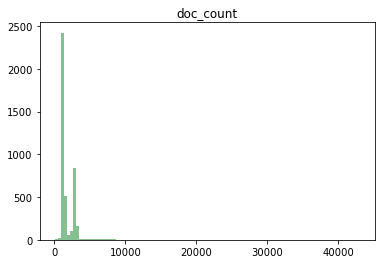

In [16]:
#pd_table.hist(column='doc_count', color='#86bf91',grid=False,bins=100)

In [53]:
# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.models.tools import HoverTool
from bokeh.models import DatetimeTickFormatter
from math import pi

In [54]:
output_notebook()  # Render inline in a Jupyter Notebook

Loading BokehJS ...

In [55]:
#print(pd_table.head())
pd_table['key_as_string']=pd.to_datetime(pd_table['key_as_string'].astype(str), format='%Y-%m-%dT%H:%M:%S.%f%z')
#print(pd_table.head())

In [56]:
#pd_table.columns.tolist()

In [57]:
sample=pd_table.sample(100)
X=sample['key_as_string'].tolist()
Y=sample['doc_count'].tolist()

In [59]:
p = figure(x_axis_type="datetime",plot_width=1200, plot_height=400)
source = ColumnDataSource(data={
    'datetime' : X,
    'count' : Y,
})
#p.circle(X, Y, size = 5, color = 'green')
p.circle(x='datetime',y='count', source=source, size = 5, color = 'green' )
p.title.text = 'Message Counts per 30 minutes'
p.background_fill_color="#f5f5f5"
p.grid.grid_line_color="white"
p.yaxis.axis_label = 'Count'
p.xaxis.axis_label =' timereported per 30 minutes'
p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
p.xaxis.major_label_orientation = pi/4

hover = HoverTool(
    tooltips=[
        ('Count', '@count{%d}'),
        ('timereported per 30 seconds','@datetime{%Y-%m-%d %H:%M:%S.%3N}')
    ],
    formatters={
        'count':'printf',
        'datetime': 'datetime',
    },
    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

p.add_tools(hover)
show(p)